In [1]:
### import machine learning algorithms
import os
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timezone
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, classification_report

/Users/chuajoonkiat/opt/anaconda3/envs/data-sci-env/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


##### SELECT FEATURES AND LOAD DATASET

In [2]:
train_df = pd.read_csv(r"./data_give_me_some_credit/cs-training.csv", low_memory=False, index_col=0)
test_df = pd.read_csv(r"./data_give_me_some_credit/cs-test.csv", low_memory=False, index_col=0)

print(train_df.shape, test_df.shape)
display(train_df.head())


(150000, 11) (101503, 11)


,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


### Data Exploration and Preprocessing

This section details a simple and straightforward visualization and preprocessing of data. There are 2 main aims here, to identify and understand how to handle outliers, and to identify and handle missing values.

The code to actually preprocess the outliers and missing values can be found further down in the **preprocess_data()** function

**Age**

As we can see there is a wide distribution of age values. For simplicity, we will remove individuals under the age of 18 since this is regarding loans.

count    150000.000000
mean         52.295207
std          14.771866
min           0.000000
25%          41.000000
50%          52.000000
75%          63.000000
max         109.000000
Name: age, dtype: float64


<AxesSubplot:xlabel='age', ylabel='Count'>

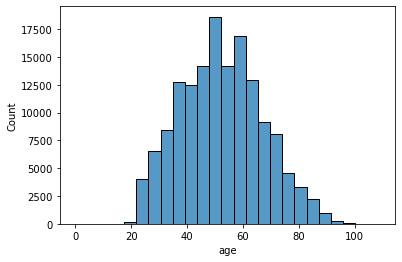

In [3]:
print(train_df.age.describe())
sns.histplot(data=train_df, x="age", bins=25)

**RevolvingUtilizationOfUnsecuredLines**

If we look at the description below, we can see that the RevolvingUtilizationOfUnsecuredLines variable has some very unusual and extreme values. That inflate the mean. As such, we will proceed to remove all values greater than the 99.8th percentile. Reason being, the 99.9th percentile has an extreme value of 1571.0 and so we use the 99.8th value

count    150000.000000
mean          6.048438
std         249.755371
min           0.000000
25%           0.029867
50%           0.154181
75%           0.559046
max       50708.000000
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64
99.8th Percentile 2.7610090134802032


<AxesSubplot:xlabel='RevolvingUtilizationOfUnsecuredLines', ylabel='Count'>

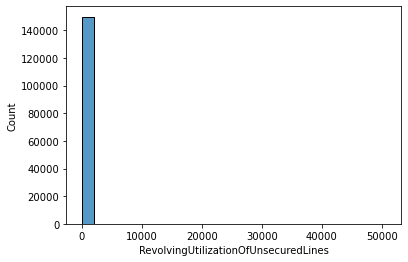

In [4]:
print(train_df["RevolvingUtilizationOfUnsecuredLines"].describe())

### Calculate nth-percentile
n = 99.8
print(f"{n}th Percentile", np.percentile(train_df["RevolvingUtilizationOfUnsecuredLines"], n))

sns.histplot(data=train_df, x="RevolvingUtilizationOfUnsecuredLines", bins=25)

**NumberOfTimes90DaysLate**

Here we can see that interestingly, there is nobody that is between 17 and 98 days late, but there are 264 people who are 98days late. While, this may seems strange, we do not want to remove these group of people as they may be severe defaulters. This is also not a concern if we are using a Random Forest model, as it is sensitive to outliers.

In [5]:
print(train_df.groupby('NumberOfTimes90DaysLate').NumberOfTimes90DaysLate.count())
train_df[train_df['NumberOfTimes90DaysLate'] > 95][['SeriousDlqin2yrs','NumberOfTime60-89DaysPastDueNotWorse','NumberOfTime30-59DaysPastDueNotWorse','NumberOfTimes90DaysLate']].describe()

NumberOfTimes90DaysLate
0     141662
1       5243
2       1555
3        667
4        291
5        131
6         80
7         38
8         21
9         19
10         8
11         5
12         2
13         4
14         2
15         2
17         1
96         5
98       264
Name: NumberOfTimes90DaysLate, dtype: int64


,SeriousDlqin2yrs,NumberOfTime60-89DaysPastDueNotWorse,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTimes90DaysLate
count,269.000000,269.000000,269.000000,269.000000
mean,0.546468,97.962825,97.962825,97.962825
std,0.498764,0.270628,0.270628,0.270628
min,0.000000,96.000000,96.000000,96.000000
25%,0.000000,98.000000,98.000000,98.000000
50%,1.000000,98.000000,98.000000,98.000000
75%,1.000000,98.000000,98.000000,98.000000
max,1.000000,98.000000,98.000000,98.000000


**NumberOfTime30-59DaysPastDueNotWorse**

Similarly, the NumberOfTime30-59DaysPastDueNotWorse variable has some very unusual and extreme values. Thus, what we will do is that we will remove all values that are greater than 3 standard deviations above the mean, and classify them as outliers. This value would be around 12-13, based on the description below.

count    150000.000000
mean          0.421033
std           4.192781
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          98.000000
Name: NumberOfTime30-59DaysPastDueNotWorse, dtype: float64
0.4210333333333333
4.192781272018315


<AxesSubplot:xlabel='NumberOfTime30-59DaysPastDueNotWorse', ylabel='Count'>

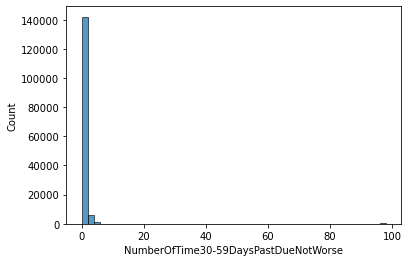

In [6]:
print(train_df["NumberOfTime30-59DaysPastDueNotWorse"].describe())

print(train_df["NumberOfTime30-59DaysPastDueNotWorse"].mean())
print(train_df["NumberOfTime30-59DaysPastDueNotWorse"].std())

sns.histplot(data=train_df, x="NumberOfTime30-59DaysPastDueNotWorse", bins=50)

**NumberOfTime60-89DaysPastDueNotWorse**

Here, the treatment is the same as the NumberOfTime30-59DaysPastDueNotWorse variable from the previous section. 

count    150000.000000
mean          0.240387
std           4.155179
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          98.000000
Name: NumberOfTime60-89DaysPastDueNotWorse, dtype: float64
99.8th Percentile 5.0


<AxesSubplot:xlabel='NumberOfTime60-89DaysPastDueNotWorse', ylabel='Count'>

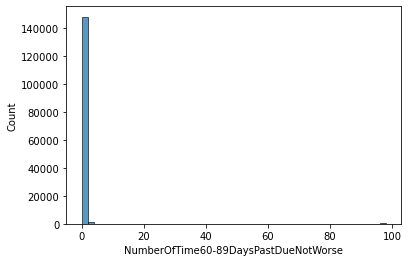

In [7]:
print(train_df["NumberOfTime60-89DaysPastDueNotWorse"].describe())

### Calculate nth-percentile
n = 99.8
print(f"{n}th Percentile", np.percentile(train_df["NumberOfTime60-89DaysPastDueNotWorse"], n))

sns.histplot(data=train_df, x="NumberOfTime60-89DaysPastDueNotWorse", bins=50)

**DebtRatio**

When we observe the debt ratio we can see that most of the values are less than 1. Here the definition of debt ratio is "Monthly debt payments, alimony, living costs divided by monthy gross income". Here we will remove values greater than the 97.5th percentile.

count    150000.000000
mean        353.005076
std        2037.818523
min           0.000000
25%           0.175074
50%           0.366508
75%           0.868254
max      329664.000000
Name: DebtRatio, dtype: float64
97.5th Percentile 3489.024999999994


<AxesSubplot:xlabel='DebtRatio', ylabel='Count'>

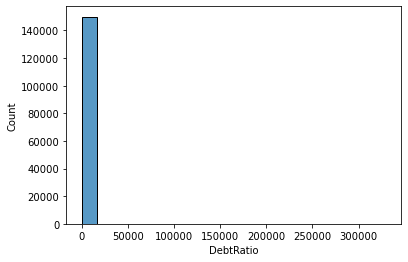

In [8]:
#print(train_df.loc[train_df["MonthlyIncome"].notnull()]["DebtRatio"].describe())
print(train_df["DebtRatio"].describe())

### Calculate nth-percentile
n = 97.5
print(f"{n}th Percentile", np.percentile(train_df["DebtRatio"], n))

sns.histplot(data=train_df, x="DebtRatio", bins=20)

##### MISSING VALUES

In [9]:
### Count Number of Missing Values
train_df.isna().sum()

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

**Monthly Income**

From the visualization below, we can see that the monthly income variable is heavily right skewed, which makes it difficult to impute with a constant value. 

/Users/chuajoonkiat/opt/anaconda3/envs/data-sci-env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


5400.0


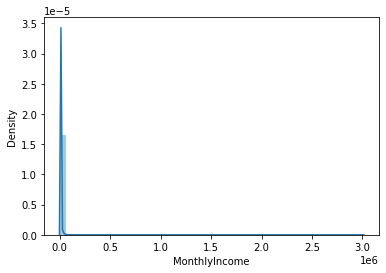

In [10]:
sns.distplot(train_df['MonthlyIncome'].dropna())
print(train_df["MonthlyIncome"].median())

**Number of Dependents**

As the number of dependents has a number of missing values. We will first visualize the data and decide how to handle the missing values. From our visualization, we can see that there the mode of the distribution is 0. As such, we can impute number of dependents as 0 if the value is missing. Furthermore, if someone leaves this column blank, it is likely that they have no dependents. 

0.0


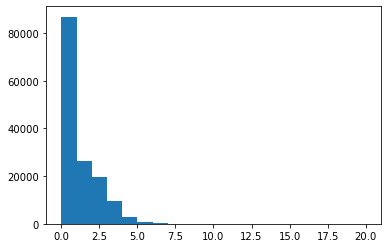

In [11]:
plt.hist(train_df['NumberOfDependents'], bins=20)
print(train_df["NumberOfDependents"].median())

##### FEATURE SELECTION
Select only the features to keep and drop the rest. Features that are kept are based on earlier data exploration

In [12]:
target=["SeriousDlqin2yrs"]
features = [x for x in train_df.columns if x != "SeriousDlqin2yrs"]

print(f"Features: {features}")

Features: ['RevolvingUtilizationOfUnsecuredLines', 'age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents']


##### DATASET UTILITY FUNCTIONS
Create a set of utility functions for use with the dataset, mainly for loading and preprocessing

In [13]:
#%%writefile ./utils.py

def preprocess_data(dataset, base_dataset):
    ### Preprocess Age
    age = 18
    dataset = dataset[dataset["age"] >= age]

    ### Preprocess RevolvingUtilizationOfUnsecuredLines
    n = 99.8
    percentile = np.percentile(base_dataset["RevolvingUtilizationOfUnsecuredLines"], n)
    dataset = dataset[dataset["RevolvingUtilizationOfUnsecuredLines"]<=percentile]

    ### Preprocess NumberOfTime30-59DaysPastDueNotWorse
    dpd59_mean = base_dataset["NumberOfTime30-59DaysPastDueNotWorse"].mean()
    dpd59_std = base_dataset["NumberOfTime30-59DaysPastDueNotWorse"].std()
    dpd59_cutoff = dpd59_mean + (dpd59_std * 3)
    dataset = dataset[dataset["NumberOfTime30-59DaysPastDueNotWorse"]<=dpd59_cutoff]

    ### Preprocess NumberOfTime60-89DaysPastDueNotWorse
    dpd89_mean = base_dataset["NumberOfTime60-89DaysPastDueNotWorse"].mean()
    dpd89_std = base_dataset["NumberOfTime60-89DaysPastDueNotWorse"].std()
    dpd89_cutoff = dpd89_mean + (dpd89_std * 3)
    dataset = dataset[dataset["NumberOfTime60-89DaysPastDueNotWorse"]<=dpd89_cutoff]

    ### Preprocess DebtRatio
    n = 97.5
    percentile_debt = np.percentile(base_dataset["DebtRatio"], n)
    dataset = dataset[dataset["DebtRatio"]<=percentile_debt]

    ### Fill NULL values with the median
    dataset = dataset.fillna(dataset.median())

    return dataset

    
class Dataset:
    
    def __init__ (self, data, features, target):
        self.data = data.copy()
        self.features = features
        self.target = target


    def train_test_split(self, standardize=None):

        X = self.data[self.features]
        y = self.data[self.target]

        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            test_size=0.2,
            random_state=8,
            shuffle=True)
            
        if standardize:
            scale_params = {
                'minmax': MinMaxScaler(),
                'standard': StandardScaler()
            }
            dtypes= list(zip(X.dtypes.index, map(str, X.dtypes)))
            print(dtypes)
            for column, dtype in dtypes:
                if dtype == 'float32' or dtype == 'float64':

                    scaler = scale_params[standardize]
                    var = np.asarray(X_train[column]).reshape(-1,1)
                    scaler.fit(var)
                    print(f"Prior Mean: {X_train[column].mean()}")

                    X_train[column] = scaler.transform(np.asarray(X_train[column]).reshape(-1,1))
                    X_test[column] = scaler.transform(np.asarray(X_test[column]).reshape(-1,1))
                    print(f"Standardization method: {standardize}; Column Name: {column}")
                    print(f"Standardized Mean: {X_train[column].mean()}\n")
        else:
            print("Data standardization is not defined")


        print(f"X_train_shape:{X_train.shape}, y_train_shape:{y_train.shape}")
        print(f"X_test_shape:{X_test.shape}, y_test_shape:{y_test.shape}")

        return X_train.values, X_test.values, y_train.values, y_test.values

##### RANDOM FOREST CLASSIFIER MODEL CLASS

In [14]:
class Model:

    def __init__ (self):
        self.best_params_ = None
    
    @staticmethod
    def build(model_params):
        if model_params:
            classifier = RandomForestClassifier(
                **model_params
            )
        else:
            print("Model Parameters Not Specified - Initiating other Params")
            classifier = RandomForestClassifier(
                n_estimators= 100,
                max_depth=8,
                min_samples_leaf=5,
                min_samples_split=3,
                max_features="sqrt"
            )
        return classifier
    
    def gridsearch(self, X_train, y_train, grid_params):
        import warnings
        warnings.filterwarnings('ignore')
         
        model = RandomForestClassifier()
        classifier = GridSearchCV(
            estimator=model,
            param_grid=grid_params,
            scoring='roc_auc',
            cv=5,
            verbose=1,
            return_train_score=True
        )
        classifier.fit(X_train, y_train.ravel())
        print("BEST GRIDSEARCH PARAMETERS:", classifier.best_params_, classifier.best_estimator_)
        return classifier

    
def train_and_evaluate(model, data, get_proba=False, threshold=None):
    X_train, X_test, y_train, y_test = data[0], data[1], data[2], data[3]
    model.fit(X_train, y_train.ravel())
    
    if get_proba:
        # Replace predict method with predict_proba method to generate probabilities
        model.predict = model.predict_proba
        y_pred_proba = model.predict(X_test)
    else:
        #y_pred=model.predict(X_test)
        if threshold is not None:
            y_pred=(model.predict_proba(X_test)[:,1] >= threshold).astype(bool)
        else:
            y_pred=model.predict(X_test)
        y_pred_proba=model.predict_proba(X_test)
        acc_score = accuracy_score(y_test, y_pred)
        print(f"Accuracy Score: {acc_score}")
    
    auc_score = roc_auc_score(y_test, y_pred_proba[:,1])
    print(f"AUC ROC Score: {auc_score}\n")

    # Print Classification Report
    report = (
        classification_report(y_test, y_pred, target_names=["class 0", "class 1"])
    )
    print(report)

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test,  y_pred_proba[:,1])

    plt.plot(fpr,tpr)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    try:
        best_params = model.best_params_
        print(best_params)
    except:
        print("\nBest Params Attribute Unavailable")
    
    return model


##### LOAD AND SPLIT THE DATA AND PREPROCESS BEFORE TRAINING

Next, we split the data into 2 datasets. A training set and the holdout set. 
- Training Set: Used for building and training the model.
- Holdout Set: This dataset is not used for model training. Instead it is used for model validation, we use this as the so called unseen data to give a better benchmark on how our model performs

In [15]:
train_df = pd.read_csv(r"./give_me_some_credit_data/cs-training.csv", low_memory=False, index_col=0)

target=["SeriousDlqin2yrs"]
features = [x for x in train_df.columns if x != "SeriousDlqin2yrs"]

### Next we split the training set into one for training and one for holdout
train_data = train_df.sample(frac=0.9)
holdout_data = train_df.drop(train_data.index)
print("BEFORE PREPROCESSING:", train_data.shape)

train_data = preprocess_data(dataset=train_data, base_dataset=train_df)
print("AFTER PREPROCESSING:", train_data.shape)
display(train_data.head())

BEFORE PREPROCESSING: (135000, 11)
AFTER PREPROCESSING: (131119, 11)


,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
10754,0,0.000000,62,0,0.146081,10500.0,6,0,1,0,0.0
6853,0,0.096045,42,0,0.201449,12970.0,8,0,2,0,0.0
58691,0,1.000000,38,0,1984.000000,5400.0,2,0,2,0,0.0
111843,0,0.000087,66,0,0.002381,10500.0,13,0,0,0,0.0
94917,0,0.137699,77,0,0.208223,2650.0,6,0,0,0,0.0


In [16]:
holdout_data = preprocess_data(dataset=holdout_data, base_dataset=train_df)
print(holdout_data.shape)
display(holdout_data.head())

(14573, 11)


,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
19,0,0.221813,43,0,0.527888,3280.0,7,0,1,0,2.0
20,0,0.602794,25,0,0.065868,333.0,2,0,0,0,0.0
22,1,0.025656,38,0,0.475841,3000.0,7,0,1,0,2.0
31,0,0.704074,28,1,0.155201,4200.0,8,0,0,0,0.0
34,0,0.186869,57,0,0.313812,7000.0,9,0,2,0,0.0


### HYPERPARAMETER TUNING

Here we do a simple grid search for hyperparameter tuning. We begin by defining a hyperparameter grid for the search space. Following which, we use Scikit-Learn's gridsearch library to perform the grid search, and print out the best parameters.

In [17]:
### SET HYPERPARAMETER GRID SEARCH PARAMETERS HERE
grid_params = {
                "n_estimators": range(100,200,300),
                "max_depth": range(3, 9, 1),
                "min_samples_split": range(1, 8, 2),
                "min_samples_leaf": range(1, 8, 2),
                "max_features":["log2", "sqrt"]
            }

##### INITIALIZE THE DATASET TO TUNE ON
target=["SeriousDlqin2yrs"]
features = [x for x in train_df.columns if x != "SeriousDlqin2yrs"]

TRAIN = Dataset(train_data.copy(), features, target)
X_train, X_test, y_train, y_test = TRAIN.train_test_split(standardize=None)
TRAIN_DATA = (X_train, X_test, y_train, y_test)

classifier = Model().gridsearch(X_train, y_train, grid_params=grid_params)
#classifier_train = train_and_evaluate(classifier, TRAIN_DATA, get_proba=True)
print("End of Run - Gridsearch Complete")

Data standardization is not defined
X_train_shape:(104895, 10), y_train_shape:(104895, 1)
X_test_shape:(26224, 10), y_test_shape:(26224, 1)
Fitting 5 folds for each of 192 candidates, totalling 960 fits
BEST GRIDSEARCH PARAMETERS: {'max_depth': 8, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 7, 'n_estimators': 100} RandomForestClassifier(max_depth=8, max_features='log2', min_samples_leaf=5,
                       min_samples_split=7)
End of Run - Gridsearch Complete


### MODEL TRAINING - RANDOM FOREST CLASSIFIER MODEL TRAINING

Here we train the Random Forest Classifier on the training data and not the holdout data. We begin by initiating our Random Forest Classifier using the best parameters that we got from hyperparameter tuning.

In the train_and_evaluate() function, we can see that there is a threshold value. This threshold value defines when we would classify an individual as a postive class (delinquent), by using the underlying predicted probabilities output.

Here, we set the threshold to any probability greater than 0.6 as the delinquent class (class 1). The reason for this is because we want to minimize the number of false positives, to truly identify bad actors. That said this threshold is flexible and can be defined based on requirements in the code.


Data standardization is not defined
X_train_shape:(104895, 10), y_train_shape:(104895, 1)
X_test_shape:(26224, 10), y_test_shape:(26224, 1)

EVALUATION ON TRAINING DATASET: (131119, 11)
Accuracy Score: 0.9385677242220867
AUC ROC Score: 0.8581265408698437

              precision    recall  f1-score   support

     class 0       0.94      1.00      0.97     24573
     class 1       0.65      0.05      0.10      1651

    accuracy                           0.94     26224
   macro avg       0.80      0.52      0.53     26224
weighted avg       0.92      0.94      0.91     26224



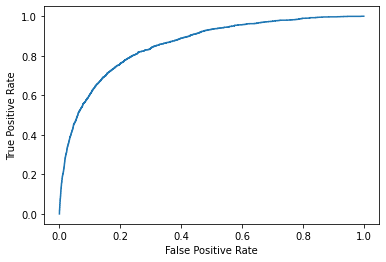


Best Params Attribute Unavailable


In [24]:
target=["SeriousDlqin2yrs"]
features = [x for x in train_df.columns if x != "SeriousDlqin2yrs"]

TRAIN = Dataset(train_data.copy(), features, target)
X_train, X_test, y_train, y_test = TRAIN.train_test_split(standardize=None)
TRAIN_DATA = (X_train, X_test, y_train, y_test)

rf_model_params = {
    "n_estimators": 100,
    "max_depth":8,
    "min_samples_leaf":5,
    "min_samples_split":7,
    "max_features":"log2"
}

### TRAIN MODEL AND EVALUATE ON TRAINING DATASET
print(f"\nEVALUATION ON TRAINING DATASET: {train_data.shape}")
classifier = Model.build(model_params=rf_model_params)    
classifier_train = train_and_evaluate(classifier, TRAIN_DATA, get_proba=False, threshold=0.6) 

##### Visualize Random Forest Architecture

Now that we have trained our random forest classifier, the next thing we can do is to visualize the "architecture" and how our decision tree looks like. We first select a random estimator amongst our Random Forest Classifier and plot is using export_graphviz() to visualize how any one of these estimators may look like 

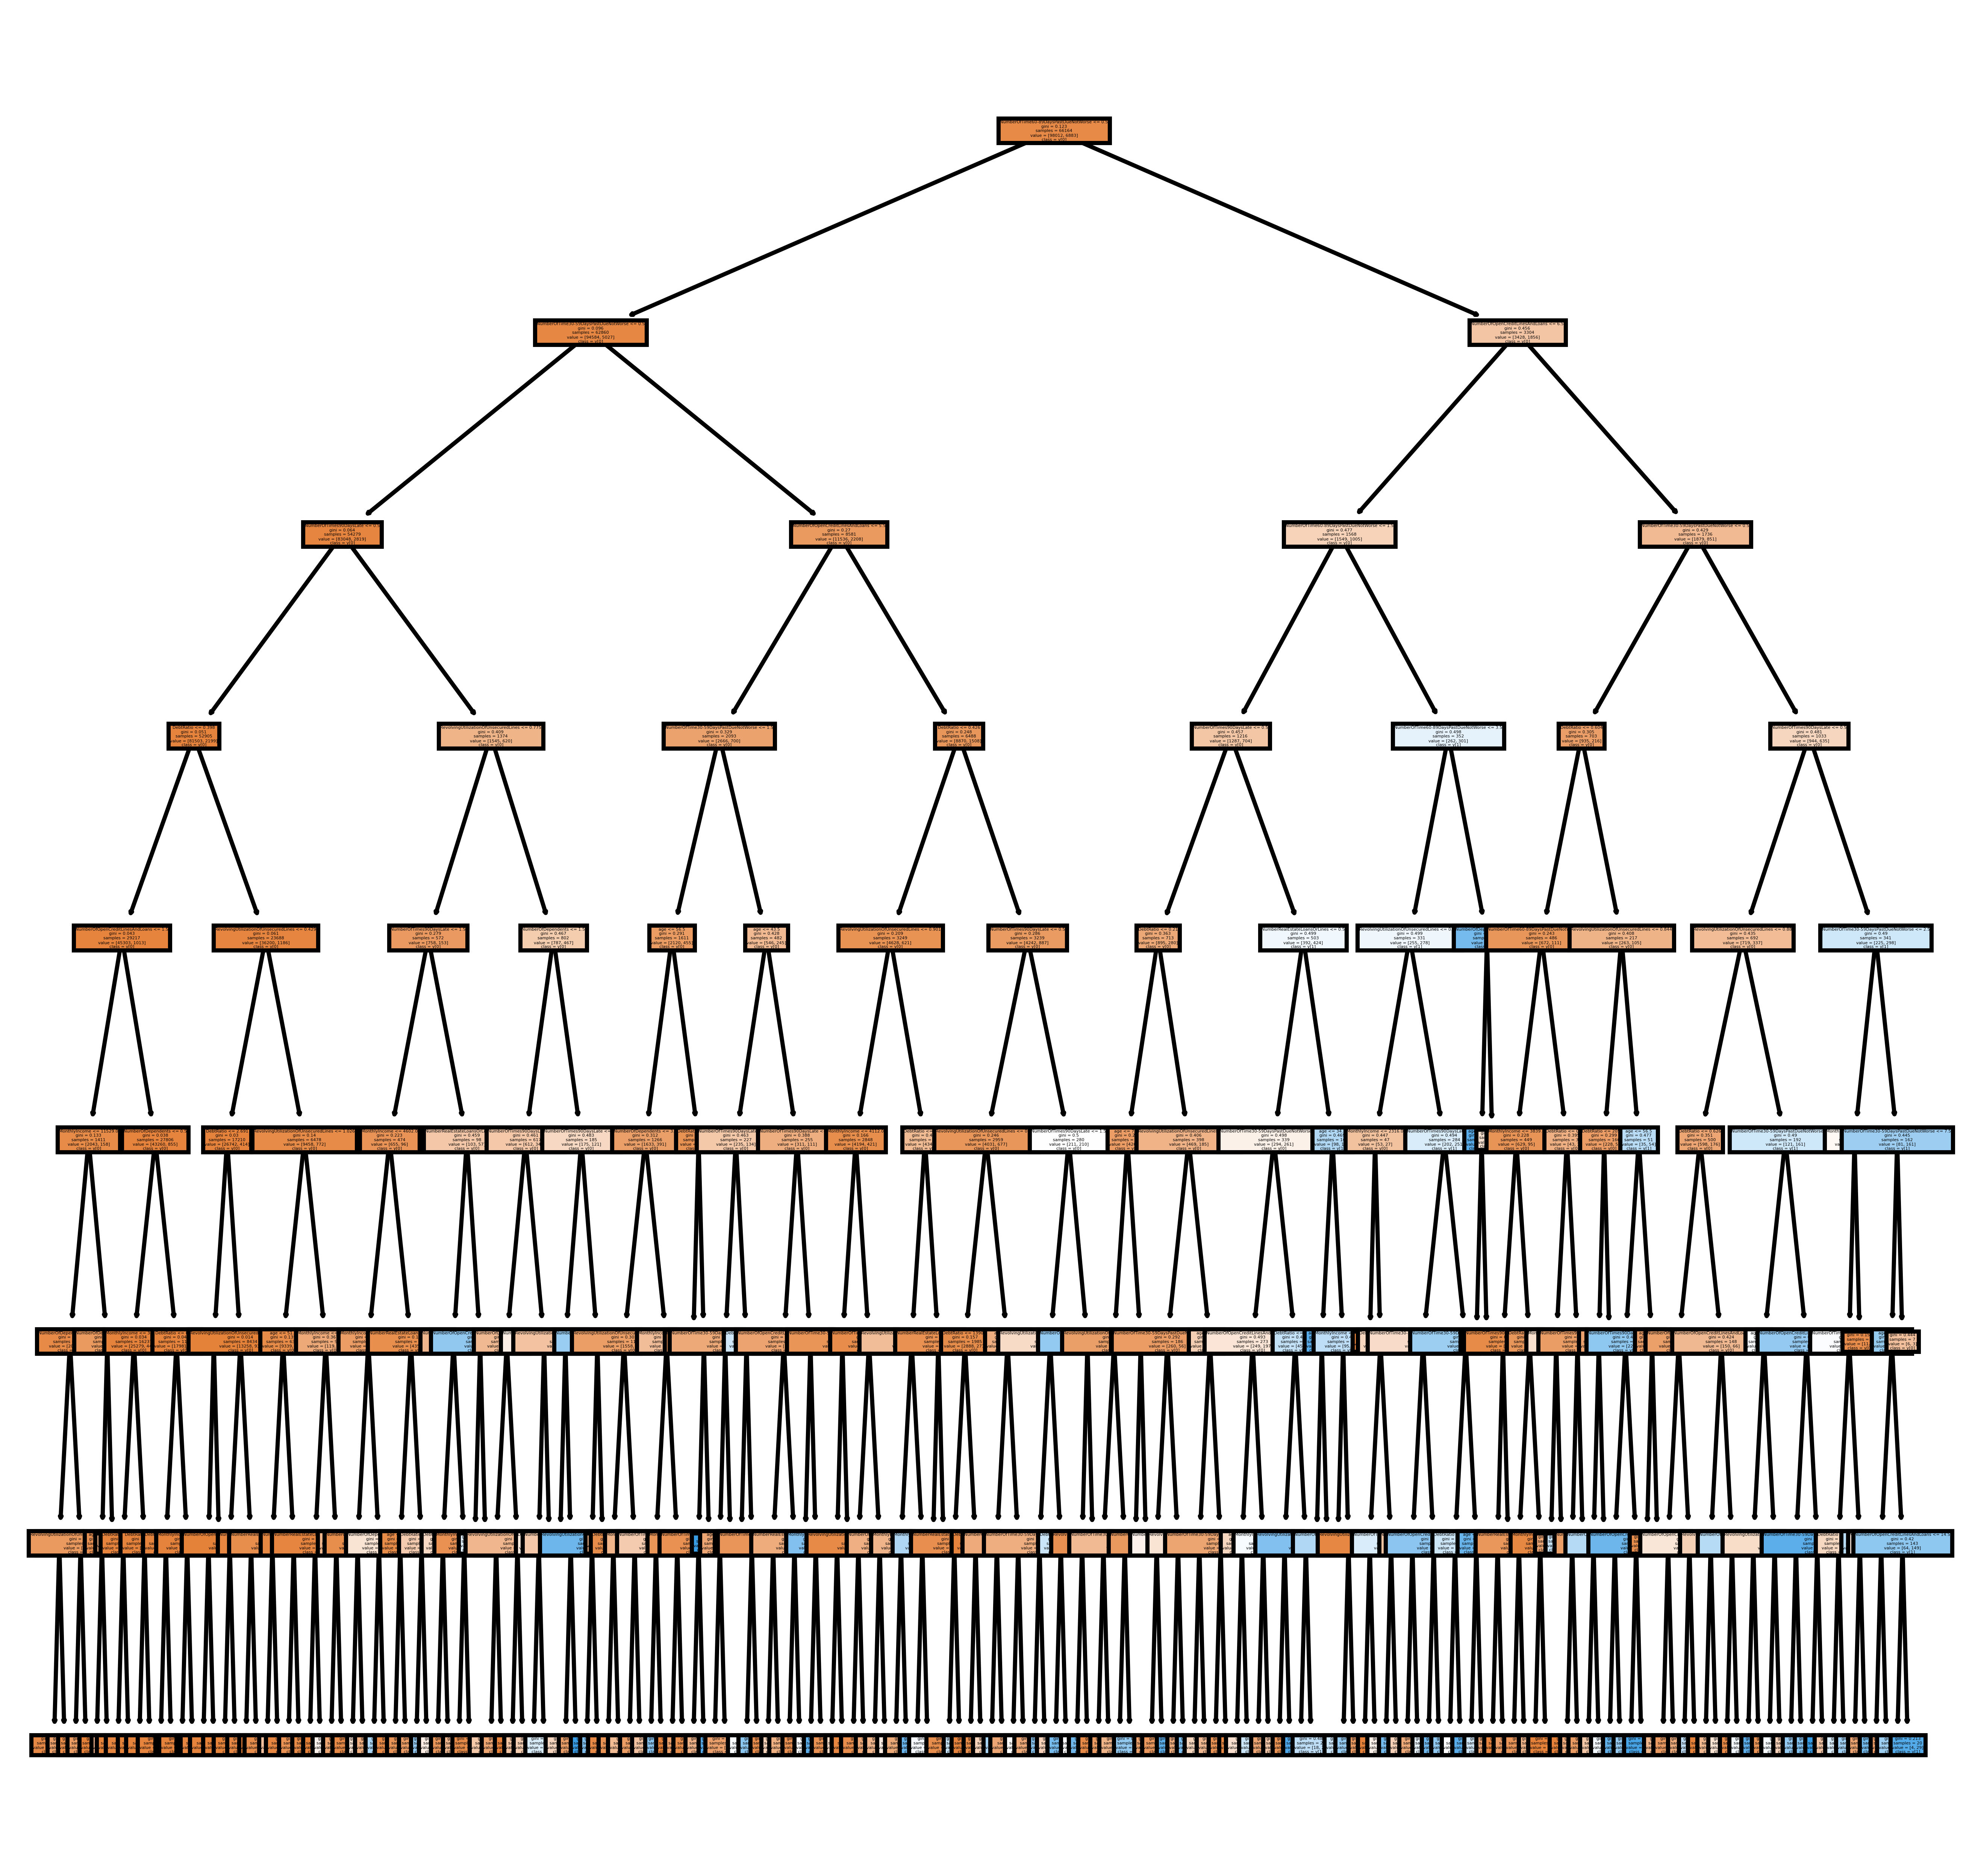

In [19]:
import os
from sklearn.tree import export_graphviz, plot_tree

# Export as dot file
estimator = classifier_train.estimators_[1]
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (8,8), dpi=800)
plot_tree(estimator,
        feature_names = features, 
        class_names=True,
        filled = True)
fig.savefig('rf_individualtree.png')

##### EVALUATE OUR MODEL ABOVE ON THE HOLDOUT SET

Interestingly, on our holdout dataset, the accuracy score and the AUC-ROC score is largely similar to that of the training dataset. The precision-recall metrics are similar as well. Nonetheless, when we compare it to the scores in the original Kaggle competition's leaderboard, the scores here still fall short.

In [23]:
### TRAIN AND EVALUATE ON HOLDOUT DATASET
print(f"\nEVALUATION ON HOLDOUT (UNSEEN) DATASET: {holdout_data.shape}")

holdout_X = holdout_data[features]
holdout_y = holdout_data[target]

#y_pred=classifier.predict(holdout_X)
threshold = 0.6
y_pred=(classifier.predict_proba(holdout_X)[:,1] >= threshold).astype(bool)
y_pred_proba=classifier.predict_proba(holdout_X)

acc_score = accuracy_score(holdout_y, y_pred)
print(f"Accuracy Score: {acc_score}")

auc_score = roc_auc_score(holdout_y, y_pred_proba[:,1])
print(f"AUC ROC Score: {auc_score}\n")

# Print Classification Report
holdout_report = (
    classification_report(holdout_y, y_pred, target_names=["class 0", "class 1"])
)
print(holdout_report)


EVALUATION ON HOLDOUT (UNSEEN) DATASET: (14573, 11)
Accuracy Score: 0.9335757908460852
AUC ROC Score: 0.8683670824829425

              precision    recall  f1-score   support

     class 0       0.93      1.00      0.97     13587
     class 1       0.65      0.04      0.08       986

    accuracy                           0.93     14573
   macro avg       0.79      0.52      0.52     14573
weighted avg       0.92      0.93      0.91     14573

